# DS250 PROJECT
## Onion Price 

### Index
0. <a href='#clean'>Data Processing</a><br>
1. <a href='#prop'>Prophet Model</a><br>
2. <a href='#val'>Validation</a><br>
3. <a href='#br'>Breakdown graphs (Visualization)</a><br>
4. <a href='#error'>Error Analysis</a><br>


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import json
from fbprophet.serialize import model_to_json, model_from_json
import warnings
import plotly.offline as pyo
pyo.init_notebook_mode()
warnings.filterwarnings('ignore')

# Data Processing
<a id='clean'></a>

- the outliers in data are removed before by analyzing std and mean of a particular window.
- Now,to remove sudden increase in prices we smoothened the curve by taking moving average.
- We split the data into traning data(total_length-14) + validation_data(7days) + test_data(7 days)

In [9]:
VEGETABLE= 'onion'
df = pd.read_csv("./data/"+VEGETABLE+'_NO_OUTLIERS.csv')
df = df.drop(['Unnamed: 0'], axis= 1)
df['DATE'] = df['DATE'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df['MODAL'] = df['MODAL'].apply(lambda x: float(x))
df = df.set_index('DATE')
df = df.rolling(7).mean()
df = df.reset_index()
df.columns = ['ds','y']
df = df.sort_values(by=['ds'])
train_data = df[:-609] #2010-2018
validation_data = df[-609:-244] #2019
test_data = df[-244:] #2020
train_validation_df = pd.concat([train_data, validation_data])


# Prophet Model
<a id='prop'></a>

In [10]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(train_data)
future = m.make_future_dataframe(periods=609)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
plot_plotly(m, forecast)

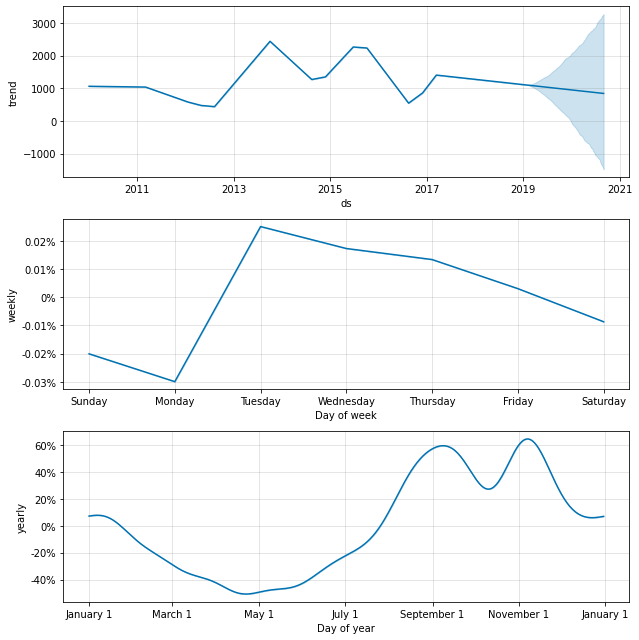

In [12]:
fig2 = m.plot_components(forecast)

# Custom Model Definition 

In [13]:
def custom_model(C1, C2, C, D, forecast, df):
    f2 = forecast.copy()
    f2['orj'] = pd.Series(df['y'].to_numpy())
    f2['m11'] = f2['m12'] = f2['m13'] = 0
    f2['m2'] = 0
    for i in range(1, len(forecast)//7-1):
        cnt = 0
        upp = 0
        low = 0
        for j in range((i-1)*7, (i)*7):
            if abs(forecast['yhat_lower'][j]-forecast['yhat_upper'][j])*C1 < abs(forecast['yhat'][j]-df['y'][j]):
                cnt += 1
            if forecast['yhat'][j]-df['y'][j] < 0:
                upp += 1
            else: low += 1
        if cnt >= C2:
            for j in range((i)*7, (i+1)*7):
                f2['yhat'][j] = C[0] * forecast['yhat'][j] + C[1] * f2['yhat'][j-7] + C[2] * df['y'][j-7] 
                f2['m11'][j] = C[0] * forecast['yhat'][j]
                f2['m12'][j] = C[1] * f2['yhat'][j-7]
                f2['m13'][j] = C[2] * df['y'][j-7]
                if upp > low:
                    f2['yhat'][j] += D[0] * forecast['yhat_upper'][j] + D[1] * forecast['yhat_upper'][j-7]
                    f2['m2'][j] = D[0] * forecast['yhat_upper'][j] + D[1] * forecast['yhat_upper'][j-7]
                else:
                    f2['yhat'][j] += D[0] * forecast['yhat_lower'][j] + D[1] * forecast['yhat_lower'][j-7]
                    f2['m2'][j] = D[0] * forecast['yhat_lower'][j] + D[1] * forecast['yhat_lower'][j-7]
                    
    f2['sqe'] = (f2['yhat'] - f2['orj'])**2
    return f2

# Validation (choosing coefficients of custom model)
<a id='val'></a>

In [14]:


def calc_train_remse(f2):
    return (f2['sqe'][:-609].sum()/(len(f2['sqe'])-609))**(1/2)
def calc_validation_rmse(f2):
    return (f2['sqe'][-609:-244].sum()/365)**(1/2)
def cal_test_rmse(f2):
    return (f2['sqe'][-244:].sum()/244)**(1/2)

X1 = np.linspace(0.1, 1, num=10)
X2 = np.linspace(0.1, 1, num=10)
X3 = np.linspace(0.1, 1, num=10)
D1 = [0.1,0.2,0.3]
D2 = [0.1,0.2,0.3]
counter = 0
validation_rmses = []
forecasts = []
for d1 in D1:
    for d2 in D2:    
        for x1 in X1:
            for x2 in X2:
                for x3 in X3:
                        if x1+x2+x3+d1+d2!=1:
                            continue
                        forecasts.append(custom_model(0.12,3,[x1,x2,x3],[d1,d2], forecast, df))
                        validation_rmses.append(([x1,x2,x3],[d1,d2],calc_validation_rmse(forecasts[-1])))
                        
print("--------CROSS VALIDATION RESULTS----------")                       
validation_rmses.sort(key= lambda x: x[2])
validation_rmses[:10]


--------CROSS VALIDATION RESULTS----------


[([0.1, 0.1, 0.6], [0.1, 0.1], 328.1825525696378),
 ([0.1, 0.2, 0.5], [0.1, 0.1], 359.5774399599345),
 ([0.1, 0.1, 0.5], [0.1, 0.2], 375.2623848644424),
 ([0.1, 0.30000000000000004, 0.4], [0.1, 0.1], 400.3216101098468),
 ([0.1, 0.2, 0.4], [0.1, 0.2], 413.1246088986146),
 ([0.1, 0.1, 0.4], [0.1, 0.3], 427.4957161930162),
 ([0.1, 0.1, 0.4], [0.2, 0.2], 429.63106643086877),
 ([0.2, 0.1, 0.5], [0.1, 0.1], 452.53660102215645),
 ([0.1, 0.4, 0.30000000000000004], [0.1, 0.1], 454.4805223554252),
 ([0.1, 0.30000000000000004, 0.30000000000000004],
  [0.1, 0.2],
  461.6482649546685)]

## TESTING RMSE 

In [15]:
selected_forecast = custom_model(0.12,3, [0.1, 0.1, 0.6], [0.1, 0.1], forecast, df)
test_rmse = cal_test_rmse(selected_forecast)
print("TEST RMSE: ", test_rmse)

TEST RMSE:  254.38524650759578


In [16]:
plot_plotly(m, selected_forecast)

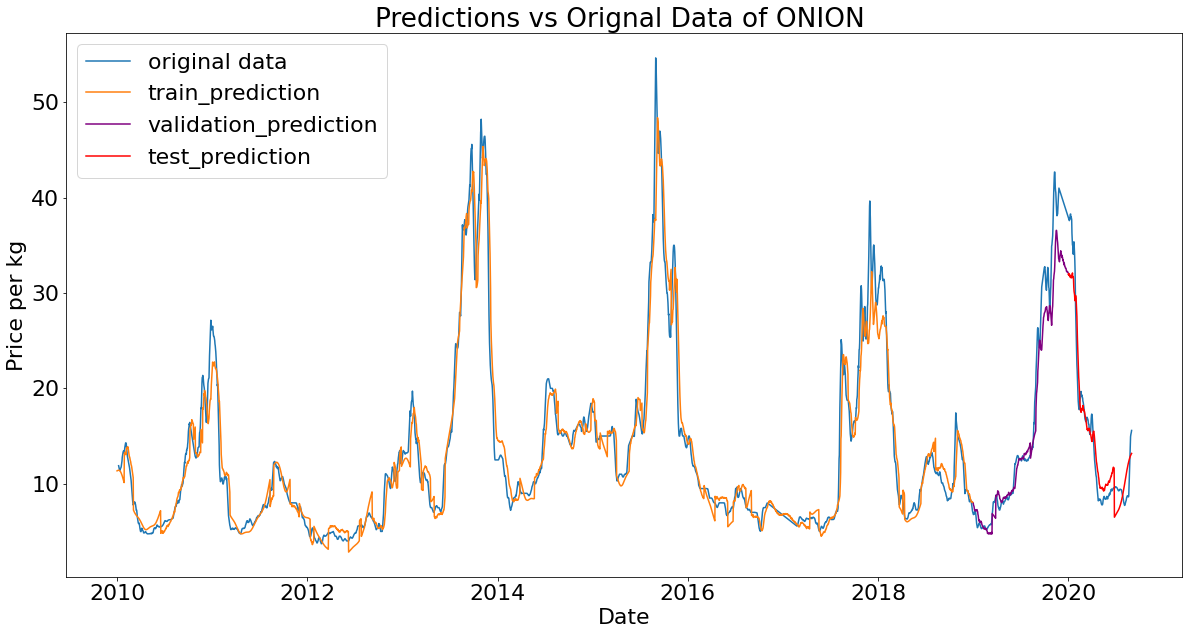

In [17]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(df['ds'], df['y']/100, label= "original data")
plt.plot(df['ds'][:-609], selected_forecast['yhat'][:-609]/100, label= "train_prediction")
plt.plot(selected_forecast['ds'][-609:-244], selected_forecast['yhat'][-609:-244]/100, color= 'purple', label= "validation_prediction")
plt.plot(selected_forecast['ds'][-244:], selected_forecast['yhat'][-244:]/100, color= 'red', label= "test_prediction")
plt.legend(loc="upper left")
plt.title("Predictions vs Orignal Data of ONION ")
plt.xlabel("Date")
plt.ylabel("Price per kg")
plt.show()

## FUTURE PREDICTIONS

In [18]:
#prediction on model trained on 2010-2018 data
prediction_future = m.make_future_dataframe(periods=609)
final_forecast = m.predict(prediction_future)
final_forecast = custom_model(0.25,3, [0.1, 0.1, 0.6], [0.1, 0.1], final_forecast, df)


In [19]:
future_prediction_values = final_forecast['yhat'][-7:]

# Breakdown graphs (Visualization) of custom model
<a id='br'></a>

In [20]:
cst = custom_model(0.12,3, [0.1, 0.1, 0.6], [0.1, 0.1], forecast, df)

## Prophet prdictions + data + forecast
<font color='#003f5c'>Shaded portions(color: #003f5c)</font> represent where prophet's predictions are used without any modifications 

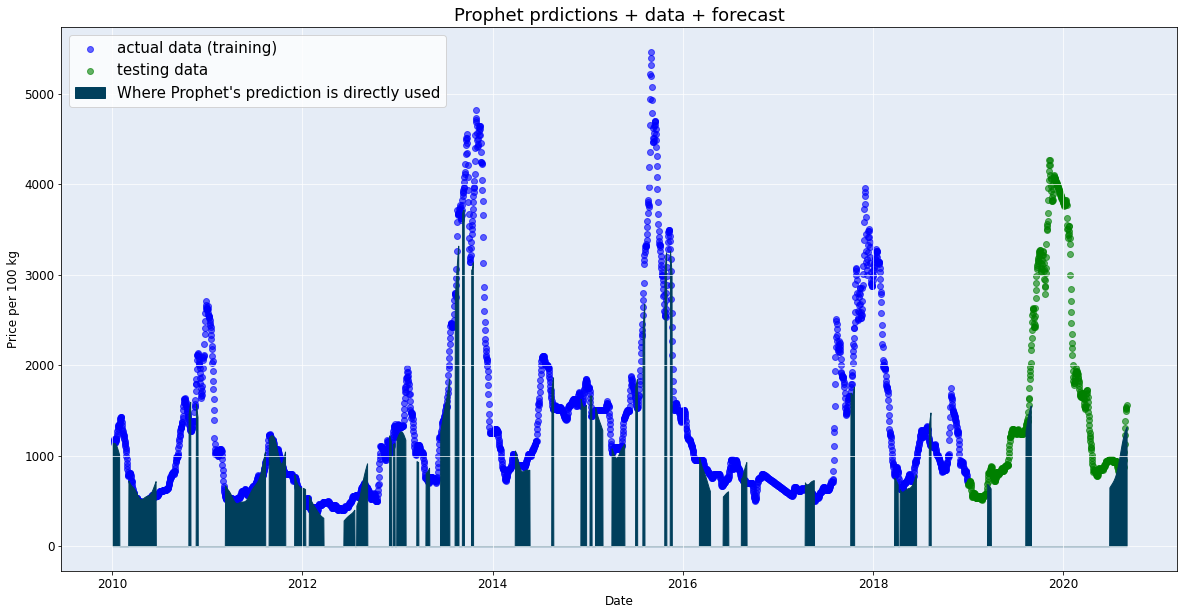

In [33]:
colors = ['#003f5c', '#444e86', '#955196', '#dd5182', '#ff6e54', '#ffa600']
cp = cst['yhat'].copy()
for i in range(len(cp)):
    if cst['m2'][i] != 0:
        cp[i] = 0

plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor('#e5ecf6')

plt.grid(True, linewidth=1.0, color='white', linestyle='-', alpha=0.7)
plt.scatter(train_data['ds'], train_data['y'], color='blue', alpha=0.6, label='actual data (training)')
plt.scatter(df[-609:]['ds'], df[-609:]['y'], color='green', alpha=0.6, label='testing data')
plt.fill_between(cst['ds'], cp, 0, color=colors[0], label='Where Prophet\'s prediction is directly used')
plt.rcParams.update({'font.size': 15})
plt.legend(loc="upper left")
plt.title("Prophet prdictions + data + forecast")
plt.xlabel("Date")
plt.ylabel("Price per 100 kg")
plt.show()

## Custom model predictions + data + forecast
<font color='#ff6e54'>Shaded portions(color: #ff6e54)</font> represent where Prediction with custom model modification is used

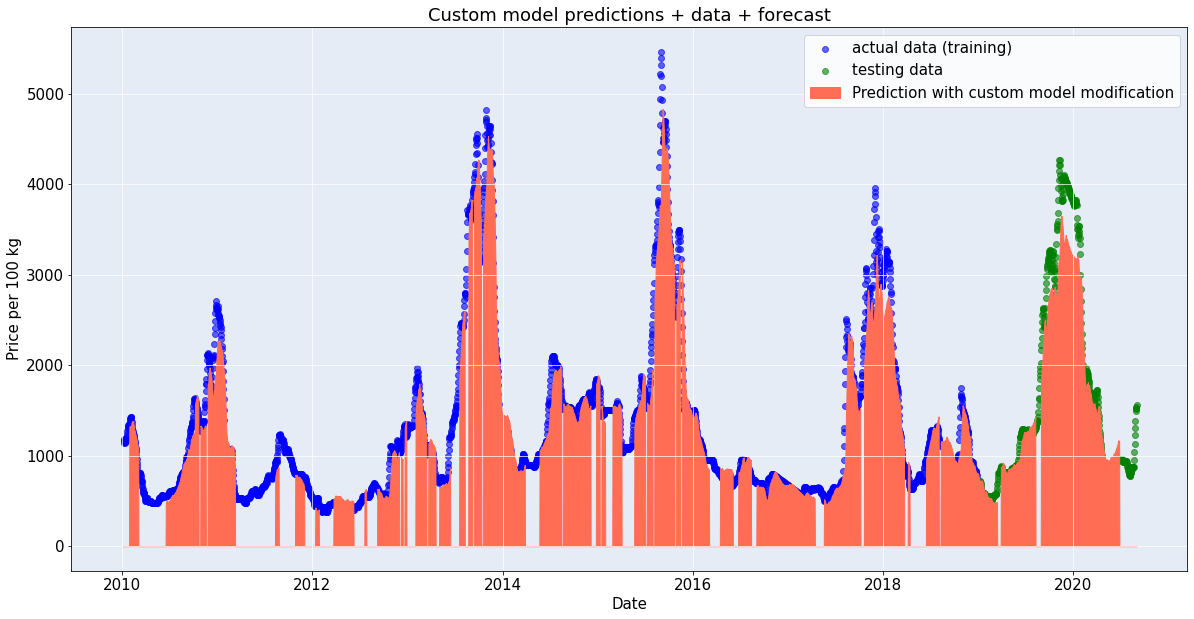

In [22]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor('#e5ecf6')
plt.grid(True, linewidth=1.0, color='white', linestyle='-', alpha=0.7)
plt.scatter(train_data['ds'], train_data['y'], color='blue', alpha=0.6, label='actual data (training)')
plt.scatter(df[-609:]['ds'], df[-609:]['y'], color='green', alpha=0.6, label='testing data')
plt.fill_between(cst['ds'], 0, cst['m13'] + cst['m11'] + cst['m12'] + cst['m2'], color=colors[4], label='Prediction with custom model modification')
plt.legend(loc="upper right")
plt.title("Custom model predictions + data + forecast")
plt.xlabel("Date")
plt.ylabel("Price per 100 kg")
plt.show()

## Custom model + prophet predictions + data + forecast

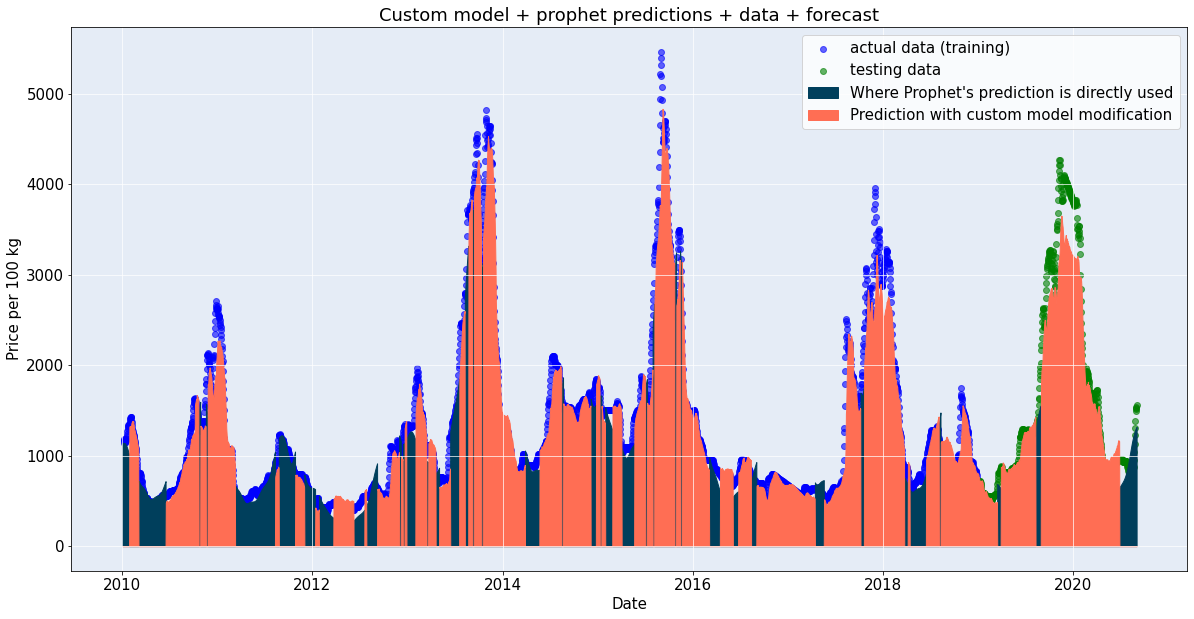

In [34]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor('#e5ecf6')

plt.grid(True, linewidth=1.0, color='white', linestyle='-', alpha=0.7)
plt.scatter(train_data['ds'], train_data['y'], color='blue', alpha=0.6, label='actual data (training)')
plt.scatter(df[-609:]['ds'], df[-609:]['y'], color='green', alpha=0.6, label='testing data')
plt.fill_between(cst['ds'], cp, 0, color=colors[0], label='Where Prophet\'s prediction is directly used')
plt.fill_between(cst['ds'], 0, cst['m13'] + cst['m11'] + cst['m12'] + cst['m2'], color=colors[4], label='Prediction with custom model modification')
plt.legend(loc="upper right")
plt.title("Custom model + prophet predictions + data + forecast")
plt.xlabel("Date")
plt.ylabel("Price per 100 kg")
plt.show()

## Breakdown of custom model components: "Last Week" component

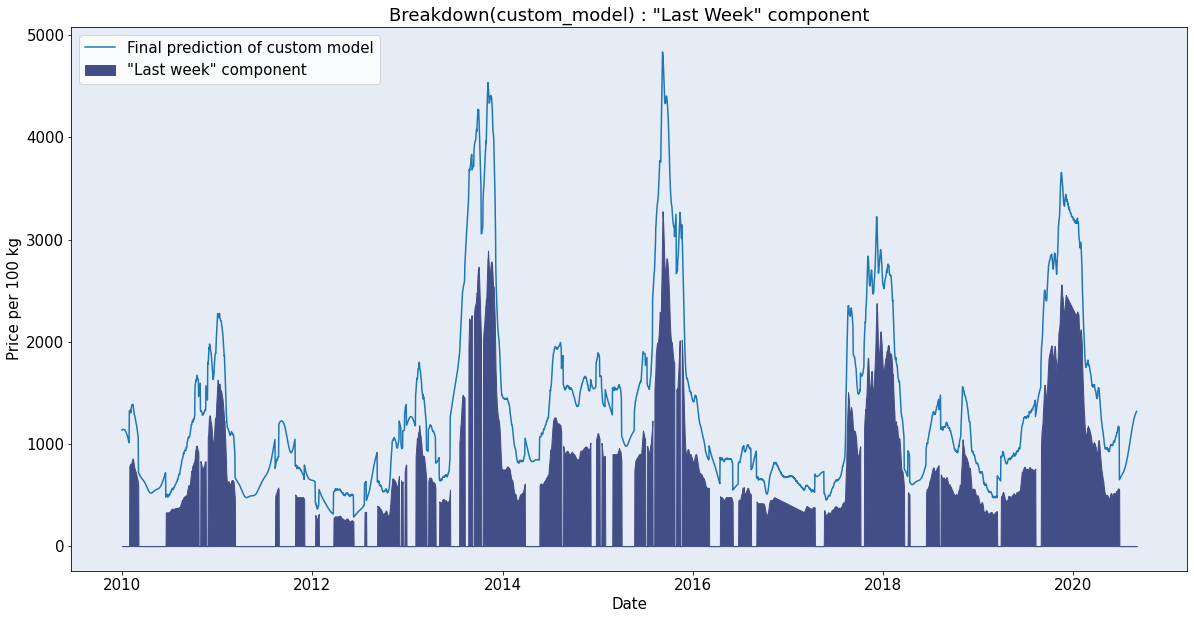

In [24]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor('#e5ecf6')
plt.plot(cst['ds'], cst['yhat'], label='Final prediction of custom model')
plt.fill_between(cst['ds'], cst['m13'], 0, color=colors[1], label='"Last week" component')
plt.legend(loc="upper left")
plt.title('Breakdown(custom_model) : "Last Week" component')
plt.xlabel("Date")
plt.ylabel("Price per 100 kg")
plt.show()

## Breakdown : "last week" component + "today's forecast" component(from prophet)

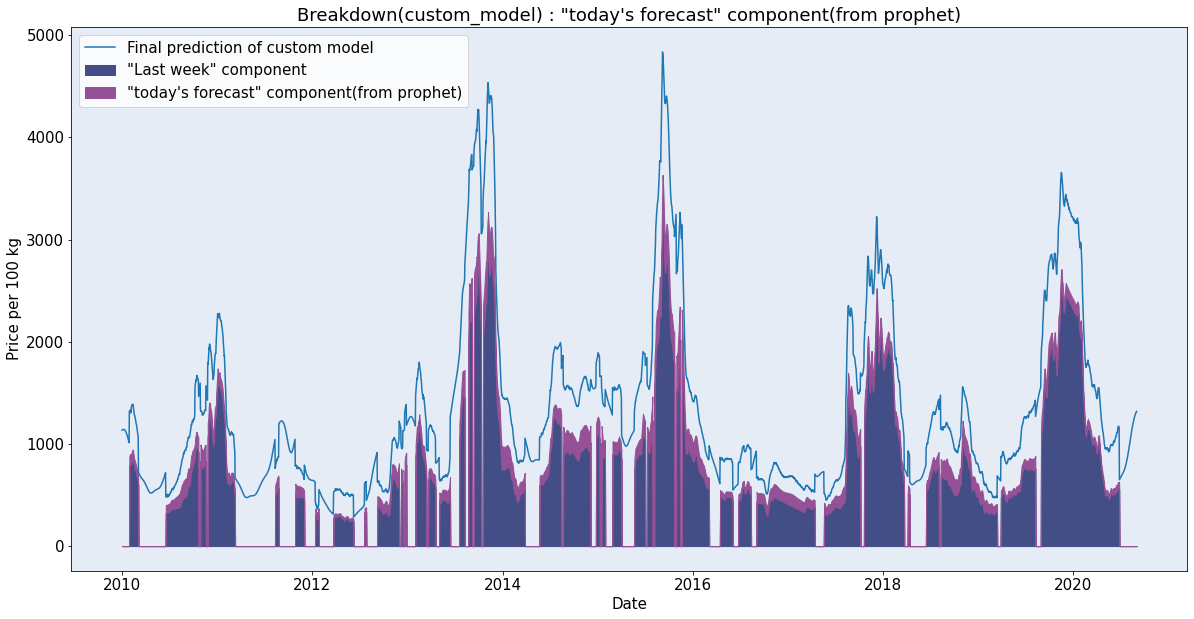

In [25]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor('#e5ecf6')
plt.plot(cst['ds'], cst['yhat'], label='Final prediction of custom model')
plt.fill_between(cst['ds'], cst['m13'], 0, color=colors[1], label='"Last week" component')
plt.fill_between(cst['ds'], cst['m13'], cst['m13'] + cst['m11'], color=colors[2], label='"today\'s forecast" component(from prophet)')
plt.legend(loc="upper left")
plt.title("Breakdown(custom_model) : \"today\'s forecast\" component(from prophet)")
plt.xlabel("Date")
plt.ylabel("Price per 100 kg")
plt.show()

## Breakdown: "last week" component + "today's forecast"(from prophet) + "last week's predition by custom model"

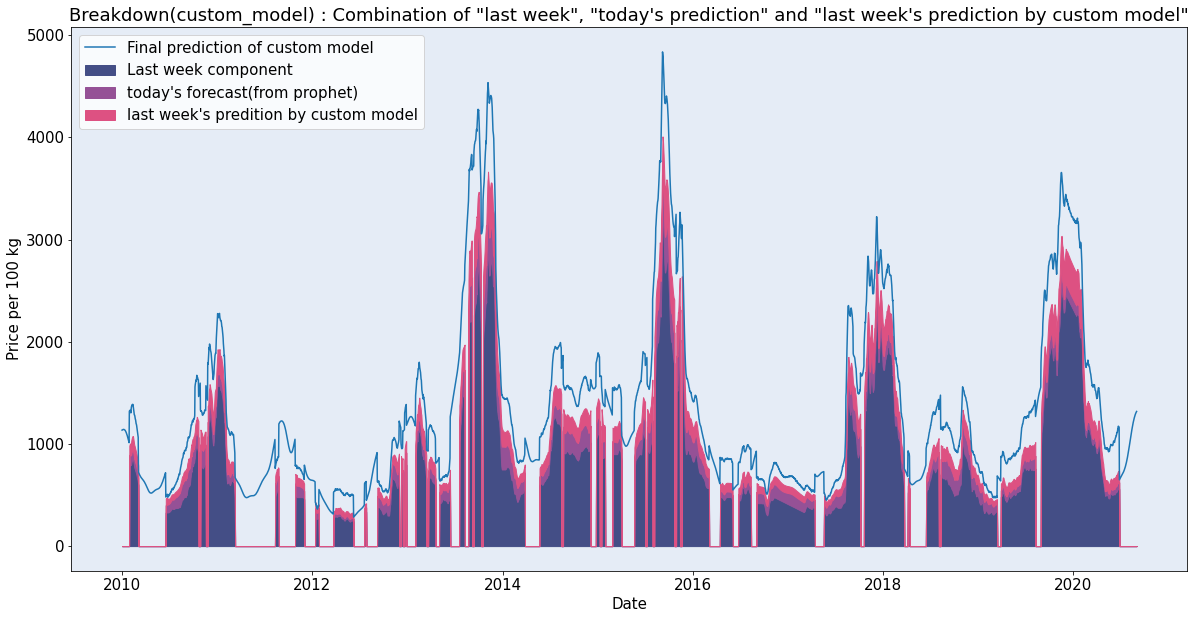

In [36]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor('#e5ecf6')
plt.plot(cst['ds'], cst['yhat'], label='Final prediction of custom model')
plt.fill_between(cst['ds'], cst['m13'], 0, color=colors[1], label='Last week component')
plt.fill_between(cst['ds'], cst['m13'], cst['m13'] + cst['m11'], color=colors[2], label='today\'s forecast(from prophet)')
plt.fill_between(cst['ds'], cst['m13'] + cst['m11'], cst['m13'] + cst['m11'] + cst['m12'], color=colors[3], label='last week\'s predition by custom model')
plt.legend(loc="upper left")
plt.title('Breakdown(custom_model) : Combination of "last week", "today\'s prediction" and "last week\'s prediction by custom model"')
plt.xlabel("Date")
plt.ylabel("Price per 100 kg")
plt.show()

## Breakdown : ... + yhat_lower/yhat_upper component

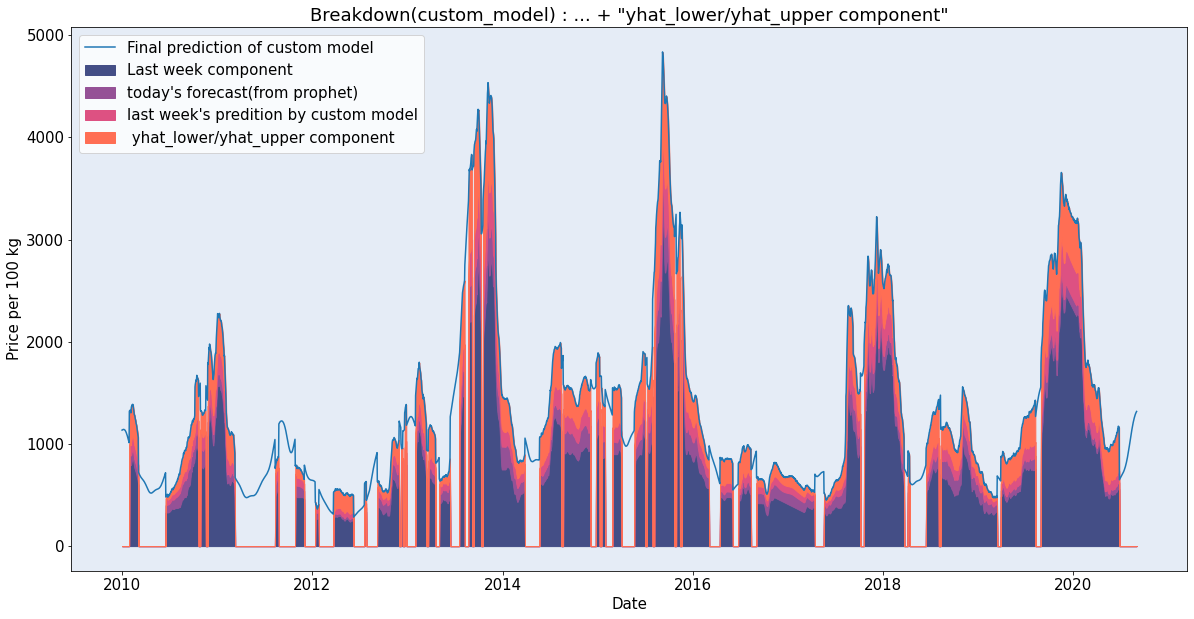

In [38]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor('#e5ecf6')
plt.plot(cst['ds'], cst['yhat'], label='Final prediction of custom model')
plt.fill_between(cst['ds'], cst['m13'], 0, color=colors[1], label='Last week component')
plt.fill_between(cst['ds'], cst['m13'], cst['m13'] + cst['m11'], color=colors[2], label='today\'s forecast(from prophet)')
plt.fill_between(cst['ds'], cst['m13'] + cst['m11'], cst['m13'] + cst['m11'] + cst['m12'], color=colors[3], label='last week\'s predition by custom model')
plt.fill_between(cst['ds'], cst['m13'] + cst['m11'] + cst['m12'], cst['m13'] + cst['m11'] + cst['m12'] + cst['m2'], color=colors[4], label=' yhat_lower/yhat_upper component')
plt.title("Breakdown(custom_model) : ... + \"yhat_lower/yhat_upper component\"")
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Price per 100 kg")
plt.show()

## Complete graph

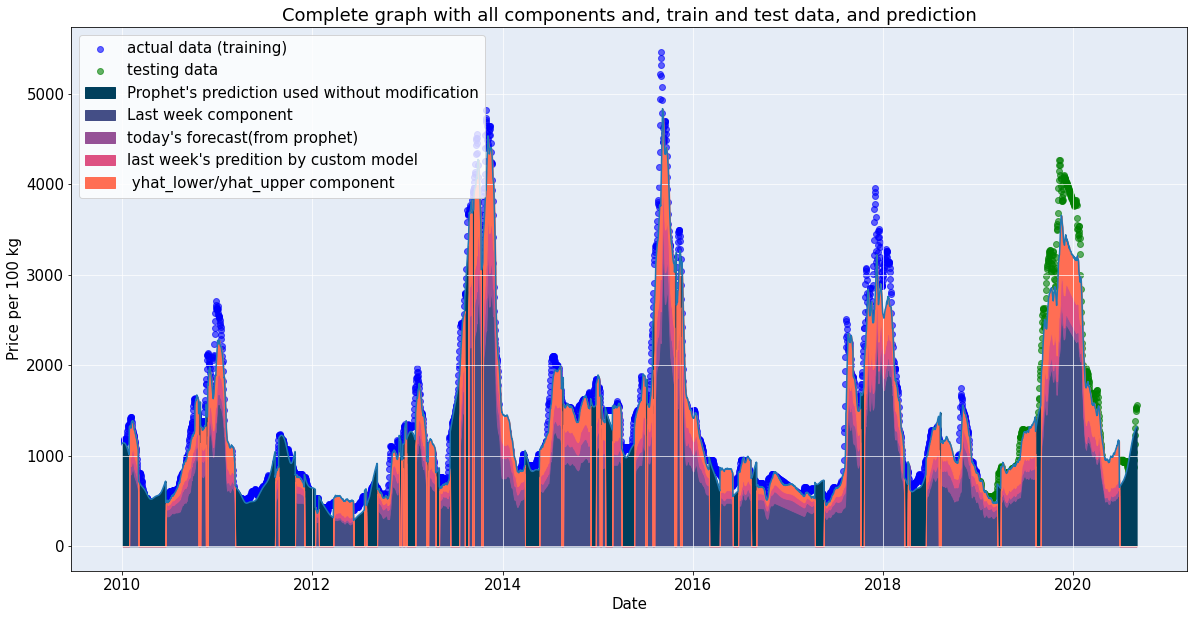

In [28]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor('#e5ecf6')
plt.grid(True, linewidth=1.0, color='white', linestyle='-', alpha=0.7)
plt.scatter(train_data['ds'], train_data['y'], color='blue', alpha=0.6, label='actual data (training)')
plt.scatter(df[-609:]['ds'], df[-609:]['y'], color='green', alpha=0.6, label='testing data')
plt.plot(cst['ds'], cst['yhat'])
plt.fill_between(cst['ds'], cp, 0, color=colors[0], label='Prophet\'s prediction used without modification')
plt.fill_between(cst['ds'], cst['m13'], 0, color=colors[1], label='Last week component')
plt.fill_between(cst['ds'], cst['m13'], cst['m13'] + cst['m11'], color=colors[2], label='today\'s forecast(from prophet)')
plt.fill_between(cst['ds'], cst['m13'] + cst['m11'], cst['m13'] + cst['m11'] + cst['m12'], color=colors[3], label='last week\'s predition by custom model')
plt.fill_between(cst['ds'], cst['m13'] + cst['m11'] + cst['m12'], cst['m13'] + cst['m11'] + cst['m12'] + cst['m2'], color=colors[4], label=' yhat_lower/yhat_upper component')
plt.legend(loc="upper left")
plt.title("Complete graph with all components and, train and test data, and prediction")
plt.xlabel("Date")
plt.ylabel("Price per 100 kg")
plt.show()

- modification of forecast values predicted by prophet by checking the error produced in previous week

# ERROR analysis
<a id="error" ></a><br>

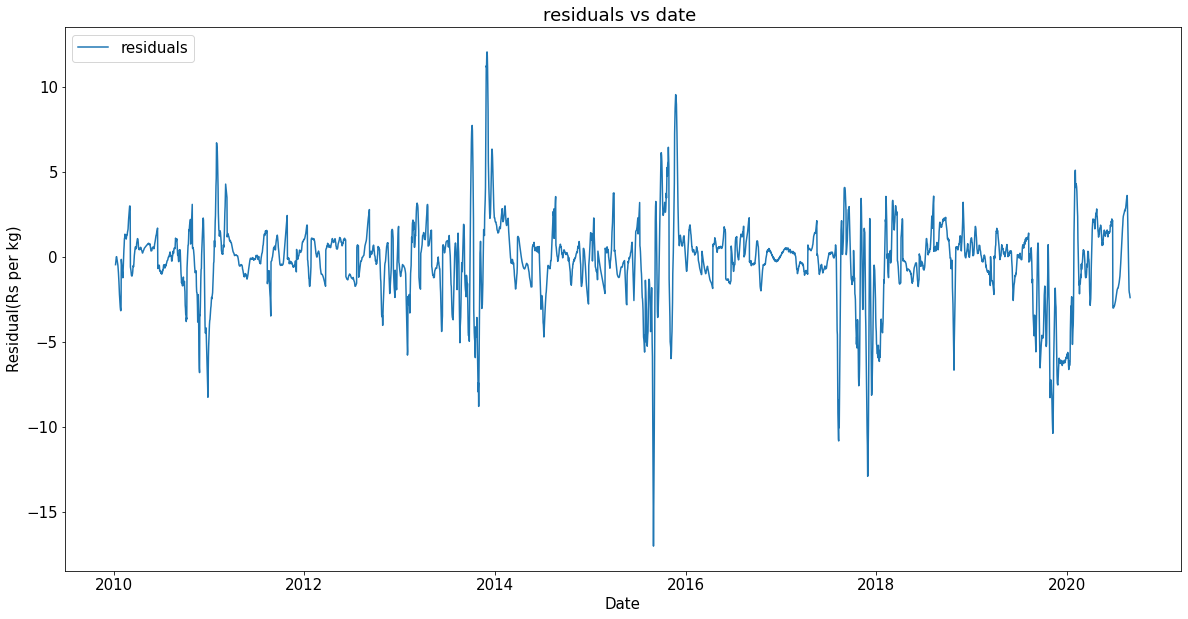

In [29]:
plt.figure(figsize=(20,10))
selected_forecast['error'] = selected_forecast['yhat'] - df['y']
plt.plot(selected_forecast['ds'], selected_forecast['error']/100, label= "residuals")
plt.legend(loc="upper left")
plt.title("residuals vs date ")
plt.xlabel("Date")
plt.ylabel("Residual(Rs per kg)")
plt.show()

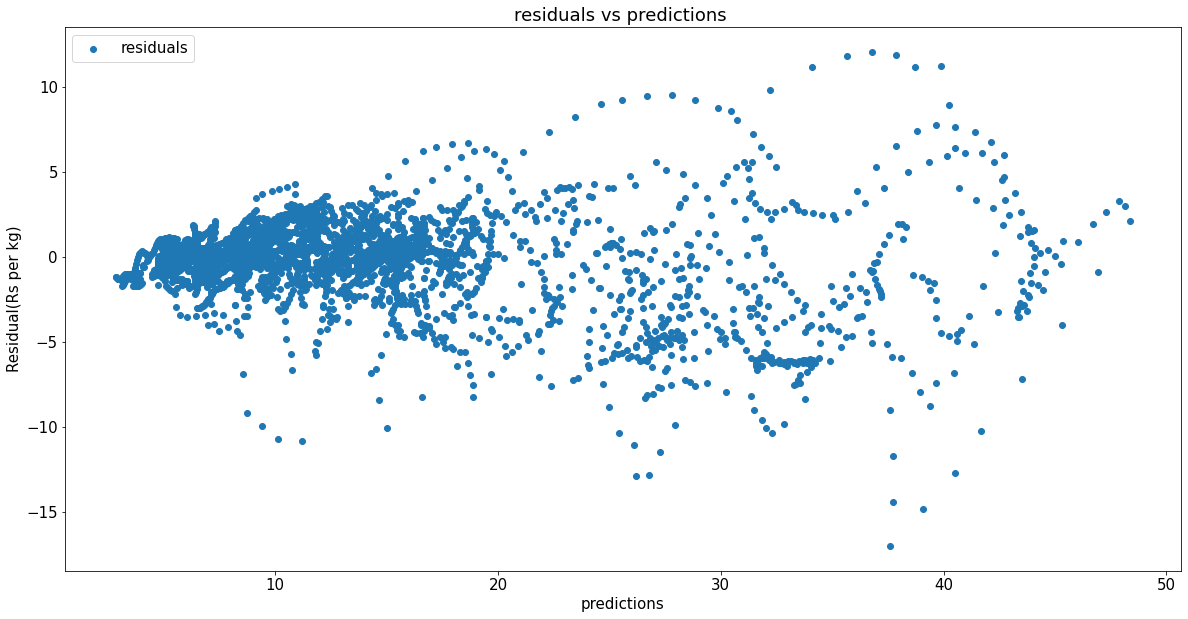

In [30]:
plt.figure(figsize=(20,10))
plt.scatter(selected_forecast['yhat']/100, selected_forecast['error']/100, label= "residuals")
plt.legend(loc="upper left")
plt.title("residuals vs predictions ")
plt.xlabel("predictions")
plt.ylabel("Residual(Rs per kg)")
plt.show()

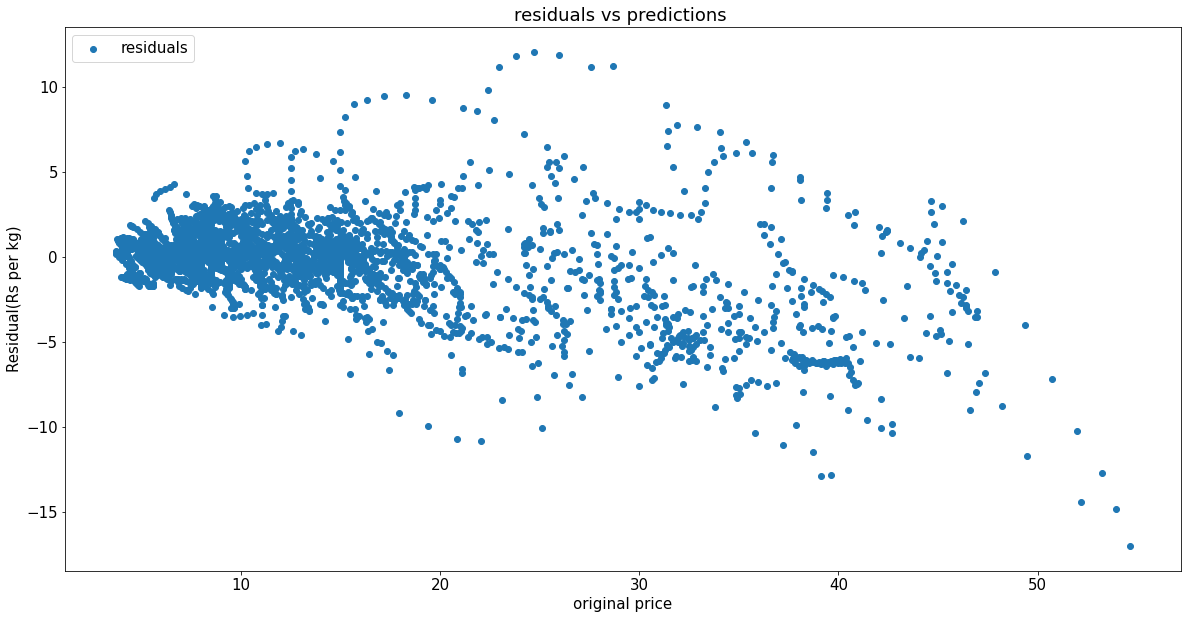

In [31]:
plt.figure(figsize=(20,10))
plt.scatter(df['y']/100, selected_forecast['error']/100, label= "residuals")
plt.legend(loc="upper left")
plt.title("residuals vs predictions ")
plt.xlabel("original price")
plt.ylabel("Residual(Rs per kg)")
plt.show()

- from the above graph we can see that there is curve like pattern
- this tells us that this model is performing poorly on higher price values as absoulute error is increasing.
- we can also see that for higher prices, the error is negative. That means the model is not able to rach the peaks(of prices) in data.

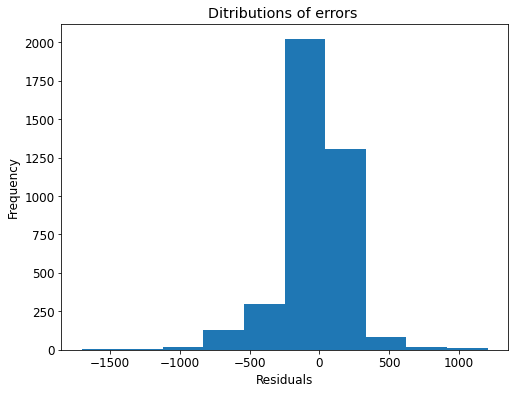

In [32]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,6))
plt.hist(selected_forecast['error'])
plt.title("Ditributions of errors ")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()